In [28]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras import layers, models
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
import cv2 as cv
import zipfile
import os

# Módulo para imprimir os gráficos de treinamento de forma dinâmica.
!pip install livelossplot

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

##Tentativa de usar o zip da pasta do meu google drive

Mounted at /content/drive/


In [16]:
!wget /content/Train_Warwick.zip
!wget /content/Test_Warwick.zip

# Extrai o conteúdo do arquivo zip
!unzip Train_Warwick.zip
!unzip Test_Warwick.zip

/content/Train_Warwick.zip: Scheme missing.
Archive:  Train_Warwick.zip
   creating: Train_4cls_amostra/
   creating: Train_4cls_amostra/0/
  inflating: Train_4cls_amostra/0/46_HER2_61709.png  
  inflating: Train_4cls_amostra/0/46_HER2_64186.png  
  inflating: Train_4cls_amostra/0/13_HER2_10243.png  
  inflating: Train_4cls_amostra/0/46_HER2_58961.png  
  inflating: Train_4cls_amostra/0/46_HER2_64180.png  
  inflating: Train_4cls_amostra/0/46_HER2_55795.png  
  inflating: Train_4cls_amostra/0/18_HER2_25188.png  
  inflating: Train_4cls_amostra/0/13_HER2_11145.png  
  inflating: Train_4cls_amostra/0/13_HER2_2910.png  
  inflating: Train_4cls_amostra/0/01_HER2_4962.png  
  inflating: Train_4cls_amostra/0/18_HER2_30785.png  
  inflating: Train_4cls_amostra/0/13_HER2_11144.png  
  inflating: Train_4cls_amostra/0/01_HER2_4153.png  
  inflating: Train_4cls_amostra/0/57_HER2_6110.png  
  inflating: Train_4cls_amostra/0/01_HER2_7841.png  
  inflating: Train_4cls_amostra/0/01_HER2_6435.png  
  

In [46]:
def load_images_from_folder(folder):
  '''Carrega as imagens dos diretorios em uma lista com o nome do arquivo e classe'''
  images = []
  for filename in os.listdir(folder):
    img = cv.imread(os.path.join(folder,filename))
    if img is not None:
      images.append((img, filename, i))
  return images

def resize_images(images):
    '''Redimensiona as imagens para 224x224 como esperado por VGG16, ResNet50'''
    resized_images = []
    for image, filename, i in images:
      resized_image = cv.resize(image, (224, 224))
      resized_images.append((resized_image, filename, i))
    return resized_images

In [88]:
# carregando as imagens em 2 listas
# Move os dados do diretório images para images/train ou images/test:
import shutil
from collections import defaultdict
import json
from pathlib import Path
import os

os.makedirs('images/train', exist_ok=True)
os.makedirs('images/test', exist_ok=True)

temp_train_images = [[],[],[],[]]
test_images = [[],[],[],[]]

for i in range(4):
  temp_train_images[i].append(load_images_from_folder('Train_4cls_amostra/' + str(i) + '/'))

for i in range(4):
  test_images[i].append(load_images_from_folder('Test_4cl_amostra/' + str(i) + '/'))

  ''' separando em treino de validação, separando as imagens de 1 paciente por
categoria (aprox. 30 imagens por paciente) temos ~20% da base de treino
Pacientes escolhidos: 01, 14, 04 e 06'''


for i in range(4):
  for image in temp_train_images[i]:
    image = resize_images(image)
    for img, filename, cat in image:
      os.makedirs('images/test/' + str(i) + '/', exist_ok=True)
      os.makedirs('images/train/'+ str(i) + '/', exist_ok=True)
      if filename.startswith('01'):
        cv.imwrite(os.path.join('images/test/' + str(i) + '/', filename), img)
      elif filename.startswith('14'):
        cv.imwrite(os.path.join('images/test/' + str(i) + '/', filename), img)
      elif filename.startswith('04'):
        cv.imwrite(os.path.join('images/test/' + str(i) + '/', filename), img)
      elif filename.startswith('06'):
        cv.imwrite(os.path.join('images/test/' + str(i) + '/', filename), img)
      else:
        cv.imwrite(os.path.join('images/train/' + str(i) + '/', filename), img)


In [89]:
# carregando as redes com transfer learning sem as camadas fuly connected

base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model_vgg16.layers:
  layer.trainable = False

for layer in base_model_resnet50.layers:
  layer.trainable = False

In [90]:
# Adicionar camadas fully connected no VGG16

# camadas próprias - você pode colocar mais se quiser
# A saída da resnet será a entrada da camada criada
x = Flatten()(base_model_vgg16.output)

# camada de classificação com as 4 classes utilizadas
prediction = Dense(4, activation='softmax')(x)

# Criação do Objeto Modelo (a parte da resnet + as camadas Fully connected criadas)
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=prediction)


##Data Augmentation

In [91]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
                                     rotation_range=90,
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.2,
                                     preprocessing_function=preprocess_input)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [92]:
import os

class_subset = sorted(os.listdir('Train_4cls_amostra/'))
print(class_subset)

['0', '1', '2', '3']


In [93]:
BATCH_SIZE = 64 # quantidade de imagens criadas em cada ciclo

traingen = train_generator.flow_from_directory('images/train',
                                               target_size=(224, 224),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory('images/train',
                                               target_size=(224, 224),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               shuffle=True,
                                               seed=42)

Found 382 images belonging to 4 classes.
Found 95 images belonging to 4 classes.


In [94]:
testgen = test_generator.flow_from_directory('images/test',
                                             target_size=(224, 224),
                                             batch_size=BATCH_SIZE,
                                             class_mode=None,
                                             classes=class_subset,
                                             shuffle=False,
                                             seed=42)

Found 116 images belonging to 4 classes.


## Treino da VGG16

In [95]:
model_vgg16.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │         100,356 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 14,815,044 (56.51 MB)

 Trainable params: 100,356 (392.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

##Treinamento VGG16 sem Data Augmentation

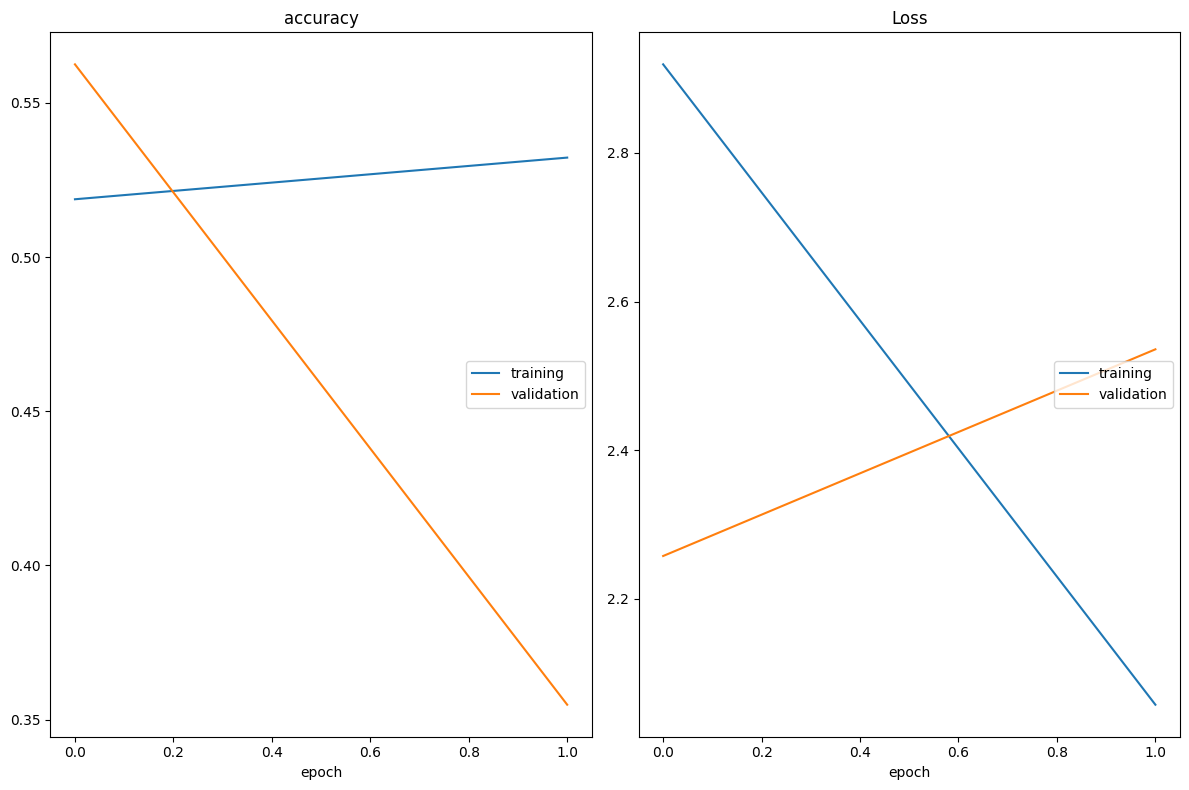

accuracy
	training         	 (min:    0.519, max:    0.532, cur:    0.532)
	validation       	 (min:    0.355, max:    0.562, cur:    0.355)
Loss
	training         	 (min:    2.057, max:    2.919, cur:    2.057)
	validation       	 (min:    2.258, max:    2.536, cur:    2.536)


AttributeError: 'NoneType' object has no attribute 'items'

In [97]:
%%time
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from livelossplot import PlotLossesKeras

steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

n_epochs = 10

optimizer = RMSprop(learning_rate=0.0001)

model_vgg16.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Salva o modelo Keras após cada época, porém só o de melhor resultado
checkpointer = ModelCheckpoint(filepath='img_model_vgg16.weights.best.keras',
                               verbose=1,
                               save_best_only=True)

# Para o treinamento para prevenir o overfitting
# Não utilizei aqui, pois queria que rodasse todas as 30 épocas
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# Treinamento do Modelo
history_tl = model_vgg16.fit(traingen,
                    epochs=n_epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    #callbacks=[checkpointer, PlotLossesKeras()],
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)